In [25]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 9

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

In [34]:
bac_df = pd.read_csv('../data/order_book/BAC_24_04.csv', index_col=[0], parse_dates=True)
bac_df

,Bid,Ask,Last,Volume,Type
Time,,,,,
2023-04-24 13:58:43.114,29.74,29.74,29.74,162.0,Buy
2023-04-24 13:58:43.167,29.73,29.74,29.74,503.0,Buy
2023-04-24 13:58:43.167,29.73,29.74,29.74,197.0,Buy
2023-04-24 13:58:43.567,29.73,29.74,29.74,200.0,Buy
2023-04-24 13:58:44.873,29.73,29.74,29.74,2000.0,Buy
...,...,...,...,...,...
2023-04-24 14:02:34.435,29.69,29.70,29.69,530.0,Sell
2023-04-24 14:02:42.038,29.69,29.70,29.70,100.0,Buy
2023-04-24 14:02:42.038,29.69,29.70,29.70,200.0,Buy


In [31]:
bk_df = pd.read_csv('../data/order_book/BK_24_04.csv', index_col=[0], parse_dates=True)
bk_df

,Bid,Ask,Last,Volume,Type
Time,,,,,
2023-04-24 13:46:02.843,44.02,44.03,44.03,100.0,Buy
2023-04-24 13:46:02.843,44.02,44.03,44.03,100.0,Buy
2023-04-24 13:46:04.876,44.01,44.02,44.02,100.0,Buy
2023-04-24 13:46:04.876,44.01,44.02,44.02,100.0,Buy
2023-04-24 13:46:04.876,44.01,44.02,44.02,100.0,Buy
...,...,...,...,...,...
2023-04-24 14:03:00.814,43.93,43.94,43.93,100.0,Sell
2023-04-24 14:03:01.235,43.93,43.94,43.93,100.0,Sell
2023-04-24 14:03:06.862,43.93,43.94,43.94,100.0,Buy


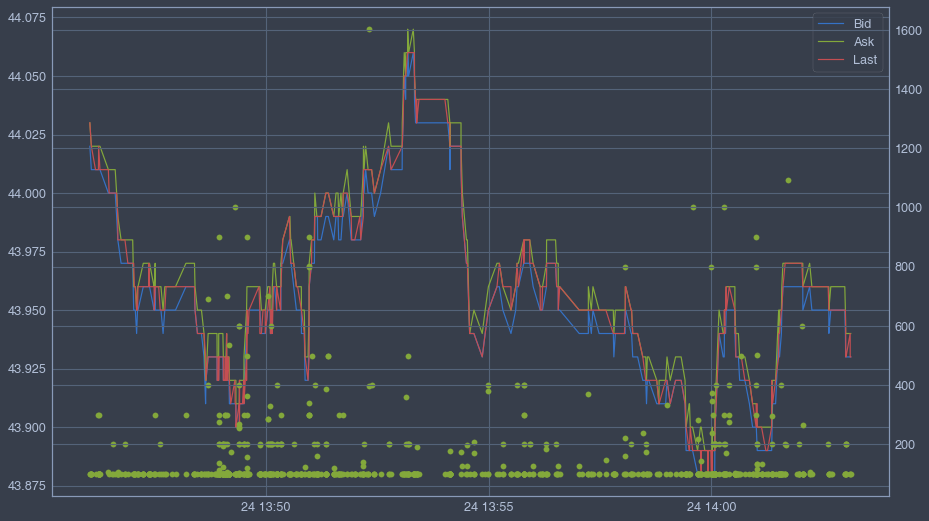

In [43]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(bk_df.index, bk_df['Bid'], label='Bid')
ax.plot(bk_df.index, bk_df['Ask'], label='Ask')
ax.plot(bk_df.index, bk_df['Last'], label='Last')
ax2.scatter(bk_df.index, bk_df['Volume'], label='Volume', c='g')
ax.grid(True)
ax.legend()